In [ ]:
# default_exp utils_tab

In [ ]:
#hide
#all_ignoretest
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#hide
!pip install fastai -Uqq
!pip install einops

In [ ]:
#hide
%cd '/content/drive/MyDrive/colab_notebooks/hmckd'
!pip3 install -e . -q

/content/drive/MyDrive/colab_notebooks/hmckd


# Building N_Point Model
> In this notebook, we will build different TabularModels to tackle the task

In [ ]:
#hide
from nbdev import * 
import seaborn as sns
from hmckd.utils import get_features, baseline_df, get_tabpandas_dls, med2como
from fastai.tabular.all import *
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
#exporti
from fastai.tabular.all import *
from hmckd.utils import get_features, baseline_df, get_tabpandas_dls, med2como

def timept_df(features:dict, timept=200, maxtimept=650):

    'prepares datapoints for a given timepoint'
  
    d = None
    for k,v in features.items():
        df = v[(v['time']!=0)]
        df = v[(v['time']<maxtimept)]
        allpat = list(v.id.unique())
        
        pair = []
        for pat in allpat:
            pattime = df[df['id']==pat]['time'].values
            pair.append((pat, min(pattime, key=lambda x:abs(x-timept))))

        value = []
        for pat, time in pair:
            value.append((pat, df[(df['id']==pat)&(df['time']==time)]['value'].values[0]))

        if d is None:
          d = pd.DataFrame(value).rename(columns={0:'id', 1:f"{k}_{timept}"})
        else:
          d = d.merge(pd.DataFrame(value).rename(columns={0:'id', 1:f"{k}_{timept}"}), on='id')

    return d


def prepare_df_ntimepoint(features, train_df, maxtimept, timepoints:list):
    
    "prepares a single dataframe for ntimepoint model based on given time points"

    bdf = baseline_df(features, train_df)
    
    for pt in timepoints: 
        bdf = bdf.merge(timept_df(features, pt), on='id')

    cont_col = ['ldl', 'creatinine', 'glucose', 'sbp', 'dbp', 'hgb']
    cont_cols = []
    for pt in timepoints:
        for col in cont_col:
            cont_cols.append(f"{col}_{pt}")
    for col in cont_col: cont_cols.append(col)
    cont_cols.append('age')
    return bdf, cont_cols


def prepare_df_firstnpt(features, train_df, n_points=6, maxtimept=650):
    'prepares dataframe for first n-points model'
    tups = []
    feats = ['hgb', 'ldl', 'glucose', 'creatinine', 'sbp', 'dbp']
    for i in range(300):
        pts = [i]
        for k in feats:
            pat = features[k][features[k]['id'] == i]
            pat = pat[pat['time'] <maxtimept]
            pat = list(pat['value'].values)

            for j in range(n_points):
                if j < len(pat): pts.append(pat[j])
                else: pts.append(np.NaN)

        tups.append(pts)

    cols = ['id']
    for feat in feats:
        for i in range(n_points):
            cols.append(f"{feat}_{i}")

    df = pd.DataFrame(tups, columns=cols)
    df = train_df[['id', 'race', 'gender', 'age', 'fold', 'Stage_Progress']].merge(df, on='id')
    
    cont_cols = cols[1:]
    cont_cols.append('age')

    return df, cont_cols

## Three-Point TabularModel 

(-10.0, 750.0)

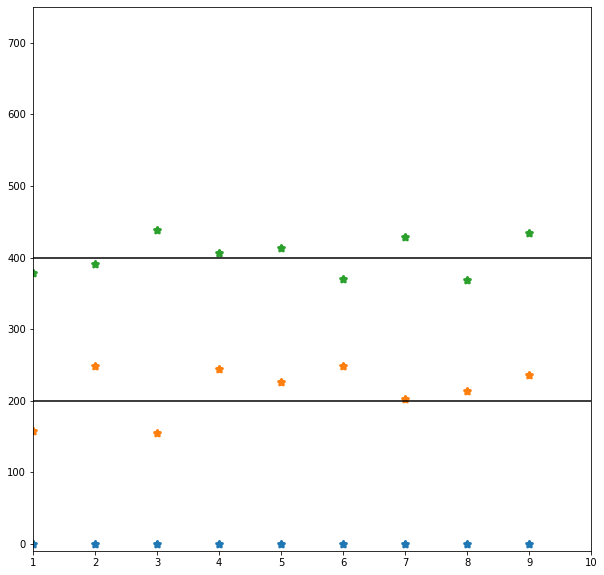

In [ ]:
#hide_input
plt.figure(figsize=(10,10))
plt.scatter(range(1,10), [0 for e in range(1, 10)], marker='*', linewidths=3)
plt.scatter(range(1,10), [200+random.randint(-50, 50) for e in range(1, 10)], marker='*', linewidths=3)
plt.scatter(range(1,10), [400+random.randint(-50, 50) for e in range(1, 10)], marker='*', linewidths=3)

plt.hlines(200, 0, 10)
plt.hlines(400, 0, 10)
plt.xlim(1,10)
plt.ylim(-10,750)

For our three-point TabularModel, we will take data points from lab meaurements at baseline and two other given time points. Example

1. Baseline datapoint
2. datapoint closes to 200 days from baseline 
3. datapoint closes to 400 days from baseline

The second and third timepoint can be a hyperparameter.

In setting up our problem as above, one of the potential issue we would face is the same data point being used for both timepoint1 and timepoint2.

In [ ]:
#hide_input
df = pd.read_csv('data/train_df_5f.csv')
features = get_features("data/dataScienceTask/")
tp1 = 200
tp2 = 400
df, cont_names = prepare_df_ntimepoint(features, df, 650, [tp1, tp2])
procs = [Categorify, FillMissing, Normalize]
cat_names = ['race', 'gender']
y_names = 'Stage_Progress'
dls, tabdf = get_tabpandas_dls(0, df, procs, cat_names, cont_names, y_names, 32)
emb_szs = get_emb_sz(tabdf)
cont_len = len(tabdf.cont_names)
learn = tabular_learner(dls, [100,50])
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6, 4)
    (1): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(19, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=26, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=100, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=2, bias=True)
    )
  )
)

The above model is what we will use. The categorical features are put through embedding layer (EL). The outputs from EL are but through  a dropout layer and a batchnorm layer before concatenating them with the continuous features. The concatenated outputs are then put through two linear layers of size 100 and 50 respectively. The linear layers are followed by a non-linear layer and a batchnorm layer. The outputs are then put through a final linear layer with 2 outputs.

Loss function of Choice : CrossEntropy

Optimizer: Adam

In [ ]:
#hide_input
print('Our continuous columns are')
print(dls.cont_names)

Our continuous columns are
['ldl_200', 'creatinine_200', 'glucose_200', 'sbp_200', 'dbp_200', 'hgb_200', 'ldl_400', 'creatinine_400', 'glucose_400', 'sbp_400', 'dbp_400', 'hgb_400', 'ldl', 'creatinine', 'glucose', 'sbp', 'dbp', 'hgb', 'age']


In [ ]:
#hide_input
print('Our categorical columns are')
print(dls.cat_names)

Our categorical columns are
['race', 'gender']


In [ ]:
#hide_output
train_df = df[df['fold']!= 4].reset_index(drop=True)
test_df = df[df['fold']== 4].reset_index(drop=True)
for i in range(4):
    dls, tabdf = get_tabpandas_dls(i, train_df, procs, cat_names, cont_names, y_names, 32)
    emb_szs = get_emb_sz(tabdf)
    learn = tabular_learner(dls, [100,50], 
                            metrics=accuracy, 
                            cbs=[SaveModelCallback(monitor='accuracy', 
                                                   fname=f'tab_3pt_{i}')])
    
    learn.fit_one_cycle(10, 0.002)

epoch,train_loss,valid_loss,accuracy,time
0,0.786663,0.713391,0.416667,00:00
1,0.731756,0.697650,0.516667,00:00
2,0.670438,0.688284,0.533333,00:00
3,0.617182,0.678632,0.583333,00:00
4,0.565198,0.679428,0.600000,00:00
5,0.519593,0.706273,0.600000,00:00
6,0.491948,0.750999,0.583333,00:00
7,0.460571,0.780184,0.583333,00:00
8,0.439010,0.804721,0.583333,00:00
9,0.419254,0.816105,0.583333,00:00


Better model found at epoch 0 with accuracy value: 0.4166666567325592.
Better model found at epoch 1 with accuracy value: 0.5166666507720947.
Better model found at epoch 2 with accuracy value: 0.5333333611488342.
Better model found at epoch 3 with accuracy value: 0.5833333134651184.
Better model found at epoch 4 with accuracy value: 0.6000000238418579.


epoch,train_loss,valid_loss,accuracy,time
0,0.839682,0.741856,0.366667,00:00
1,0.809606,0.723926,0.350000,00:00
2,0.755532,0.695431,0.416667,00:00
3,0.709863,0.673163,0.583333,00:00
4,0.662763,0.662570,0.633333,00:00
5,0.618224,0.636441,0.683333,00:00
6,0.580770,0.621356,0.633333,00:00
7,0.549717,0.615442,0.666667,00:00
8,0.521826,0.617644,0.650000,00:00
9,0.500965,0.620274,0.650000,00:00


Better model found at epoch 0 with accuracy value: 0.36666667461395264.
Better model found at epoch 2 with accuracy value: 0.4166666567325592.
Better model found at epoch 3 with accuracy value: 0.5833333134651184.
Better model found at epoch 4 with accuracy value: 0.6333333253860474.
Better model found at epoch 5 with accuracy value: 0.6833333373069763.


epoch,train_loss,valid_loss,accuracy,time
0,0.739945,0.713457,0.400000,00:00
1,0.728730,0.695737,0.516667,00:00
2,0.690042,0.665734,0.633333,00:00
3,0.652300,0.636901,0.700000,00:00
4,0.614963,0.603263,0.733333,00:00
5,0.579777,0.581690,0.766667,00:00
6,0.548223,0.568312,0.766667,00:00
7,0.523660,0.561489,0.733333,00:00
8,0.500753,0.559338,0.766667,00:00
9,0.482960,0.556869,0.733333,00:00


Better model found at epoch 0 with accuracy value: 0.4000000059604645.
Better model found at epoch 1 with accuracy value: 0.5166666507720947.
Better model found at epoch 2 with accuracy value: 0.6333333253860474.
Better model found at epoch 3 with accuracy value: 0.699999988079071.
Better model found at epoch 4 with accuracy value: 0.7333333492279053.
Better model found at epoch 5 with accuracy value: 0.7666666507720947.


epoch,train_loss,valid_loss,accuracy,time
0,0.719112,0.672140,0.616667,00:00
1,0.686358,0.639193,0.650000,00:00
2,0.660549,0.608011,0.716667,00:00
3,0.620122,0.576107,0.750000,00:00
4,0.596057,0.560116,0.683333,00:00
5,0.561166,0.542030,0.750000,00:00
6,0.535604,0.538080,0.733333,00:00
7,0.515677,0.541727,0.716667,00:00
8,0.496389,0.547556,0.716667,00:00
9,0.477305,0.552679,0.716667,00:00


Better model found at epoch 0 with accuracy value: 0.6166666746139526.
Better model found at epoch 1 with accuracy value: 0.6499999761581421.
Better model found at epoch 2 with accuracy value: 0.7166666388511658.
Better model found at epoch 3 with accuracy value: 0.75.


In [ ]:
#hide_output
test_dl = dls.test_dl(test_df)
preds = []
for i in range(4):
    dls, tabdf = get_tabpandas_dls(i, train_df, procs, cat_names, cont_names, y_names, 32)
    emb_szs = get_emb_sz(tabdf)
    learn = tabular_learner(dls, [100,50], 
                        metrics=accuracy, 
                        cbs=[SaveModelCallback(monitor='accuracy')])
    
    learn.load(f'tab_3pt_{i}')
    pred, y_pred, y_true = learn.get_preds(dl=test_dl, with_decoded=True)
    preds.append(pred)
  
y_true = test_dl.y.values
y_pred = np.array(torch.argmax(torch.stack(preds).mean(0),1))

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [ ]:
#hide_input
print(f'5-fold accuracy score: {accuracy_score(y_true, y_pred):.2f}')

5-fold accuracy score: 0.68


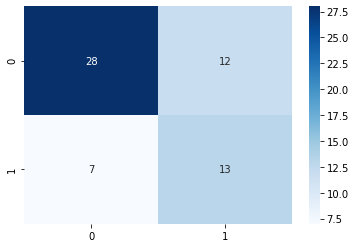

In [ ]:
#hide_input
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='Blues')

Next, we will weighted loss to account for class imbalance

In [ ]:
#hide_output
for i in range(4):
    dls, tabdf = get_tabpandas_dls(i, train_df, procs, cat_names, cont_names, y_names, 32)
    emb_szs = get_emb_sz(tabdf)
    learn = tabular_learner(dls, [100,50], 
                            metrics=accuracy, 
                            cbs=[SaveModelCallback(monitor='accuracy', 
                                                   fname=f'tab_3pt_wl_{i}')])
    learn.loss_func = CrossEntropyLossFlat(weight=tensor([0.67, 1.33]))
    
    learn.fit_one_cycle(10, 0.002)

epoch,train_loss,valid_loss,accuracy,time
0,0.737429,0.701416,0.316667,00:00
1,0.705804,0.690329,0.483333,00:00
2,0.664514,0.684995,0.550000,00:00
3,0.621660,0.687058,0.566667,00:00
4,0.585655,0.692608,0.566667,00:00
5,0.547549,0.715488,0.516667,00:00
6,0.514138,0.748011,0.566667,00:00
7,0.488025,0.768088,0.583333,00:00
8,0.465133,0.787334,0.566667,00:00
9,0.448222,0.798755,0.550000,00:00


Better model found at epoch 0 with accuracy value: 0.3166666626930237.
Better model found at epoch 1 with accuracy value: 0.4833333194255829.
Better model found at epoch 2 with accuracy value: 0.550000011920929.
Better model found at epoch 3 with accuracy value: 0.5666666626930237.
Better model found at epoch 7 with accuracy value: 0.5833333134651184.


epoch,train_loss,valid_loss,accuracy,time
0,0.738583,0.692300,0.350000,00:00
1,0.716385,0.681538,0.400000,00:00
2,0.673913,0.650367,0.616667,00:00
3,0.635664,0.634446,0.616667,00:00
4,0.595664,0.627202,0.633333,00:00
5,0.563073,0.627130,0.633333,00:00
6,0.534539,0.622490,0.633333,00:00
7,0.503075,0.625481,0.633333,00:00
8,0.482493,0.628176,0.633333,00:00
9,0.461071,0.626606,0.633333,00:00


Better model found at epoch 0 with accuracy value: 0.3499999940395355.
Better model found at epoch 1 with accuracy value: 0.4000000059604645.
Better model found at epoch 2 with accuracy value: 0.6166666746139526.
Better model found at epoch 4 with accuracy value: 0.6333333253860474.


epoch,train_loss,valid_loss,accuracy,time
0,0.753475,0.680945,0.666667,00:00
1,0.743255,0.679052,0.650000,00:00
2,0.710021,0.673369,0.666667,00:00
3,0.654102,0.672491,0.716667,00:00
4,0.613735,0.676956,0.733333,00:00
5,0.578972,0.681754,0.683333,00:00
6,0.553180,0.687502,0.683333,00:00
7,0.526147,0.689354,0.666667,00:00
8,0.506866,0.684102,0.666667,00:00
9,0.490455,0.691560,0.666667,00:00


Better model found at epoch 0 with accuracy value: 0.6666666865348816.
Better model found at epoch 3 with accuracy value: 0.7166666388511658.
Better model found at epoch 4 with accuracy value: 0.7333333492279053.


epoch,train_loss,valid_loss,accuracy,time
0,0.718661,0.707413,0.316667,00:00
1,0.707770,0.684648,0.500000,00:00
2,0.682373,0.646276,0.633333,00:00
3,0.636756,0.623433,0.633333,00:00
4,0.605016,0.609947,0.666667,00:00
5,0.574083,0.608954,0.666667,00:00
6,0.543488,0.607893,0.666667,00:00
7,0.520186,0.608876,0.633333,00:00
8,0.500572,0.609999,0.633333,00:00
9,0.483962,0.615539,0.633333,00:00


Better model found at epoch 0 with accuracy value: 0.3166666626930237.
Better model found at epoch 1 with accuracy value: 0.5.
Better model found at epoch 2 with accuracy value: 0.6333333253860474.
Better model found at epoch 4 with accuracy value: 0.6666666865348816.


In [ ]:
#hide_output
test_dl = dls.test_dl(test_df)
preds = []
for i in range(4):
    dls, tabdf = get_tabpandas_dls(i, train_df, procs, cat_names, cont_names, y_names, 32)
    emb_szs = get_emb_sz(tabdf)
    learn = tabular_learner(dls, [100,50], 
                        metrics=accuracy, 
                        cbs=[SaveModelCallback(monitor='accuracy')])
    
    learn.load(f'tab_3pt_wl_{i}')
    pred, y_pred, y_true = learn.get_preds(dl=test_dl, with_decoded=True)
    preds.append(pred)
  
y_true = test_dl.y.values
y_pred = np.array(torch.argmax(torch.stack(preds).mean(0),1))

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [ ]:
#hide_input
print(f'5-fold accuracy score: {accuracy_score(y_true, y_pred):.2f}')

5-fold accuracy score: 0.65


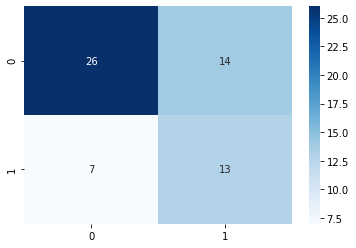

In [ ]:
#hide_input
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='Blues')

## 6_point Model

(-10.0, 750.0)

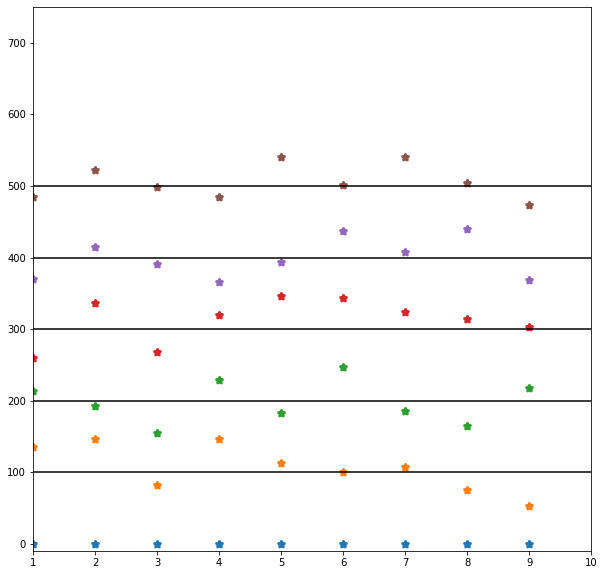

In [ ]:
#hide_input
plt.figure(figsize=(10,10))
plt.scatter(range(1,10), [0 for e in range(1, 10)], marker='*', linewidths=3)
plt.scatter(range(1,10), [100+random.randint(-50, 50) for e in range(1, 10)], marker='*', linewidths=3)
plt.scatter(range(1,10), [200+random.randint(-50, 50) for e in range(1, 10)], marker='*', linewidths=3)
plt.scatter(range(1,10), [300+random.randint(-50, 50) for e in range(1, 10)], marker='*', linewidths=3)
plt.scatter(range(1,10), [400+random.randint(-50, 50) for e in range(1, 10)], marker='*', linewidths=3)
plt.scatter(range(1,10), [500+random.randint(-50, 50) for e in range(1, 10)], marker='*', linewidths=3)

plt.hlines(100, 0, 10)
plt.hlines(200, 0, 10)
plt.hlines(300, 0, 10)
plt.hlines(400, 0, 10)
plt.hlines(500, 0, 10)
plt.xlim(1,10)
plt.ylim(-10,750)

In our 6-point model, we will take data from 6 datapoints including the baseline.

In [ ]:
#hide_input
df = pd.read_csv('data/train_df_5f.csv')
df, cont_names = prepare_df_ntimepoint(features, df, 650, [100,200,300,400,500])
procs = [Categorify, FillMissing, Normalize]
y_names = 'Stage_Progress'
y_block = CategoryBlock()
cat_names = ['race', 'gender']

In [ ]:
#hide_output
train_df = df[df['fold']!= 4].reset_index(drop=True)
test_df = df[df['fold']== 4].reset_index(drop=True)

for i in range(4):
    dls, tabdf = get_tabpandas_dls(i, train_df, procs, cat_names, cont_names, y_names, 32)
    emb_szs = get_emb_sz(tabdf)
    learn = tabular_learner(dls, [100,50], 
                            metrics=accuracy, 
                            cbs=[SaveModelCallback(monitor='accuracy', 
                                                   fname=f'tab_6pt_{i}')])
    
    learn.fit_one_cycle(10, 0.002)

epoch,train_loss,valid_loss,accuracy,time
0,0.694965,0.689141,0.533333,00:00
1,0.673334,0.682517,0.500000,00:00
2,0.617009,0.673648,0.583333,00:00
3,0.567498,0.666642,0.616667,00:00
4,0.517325,0.670636,0.600000,00:00
5,0.474341,0.681502,0.616667,00:00
6,0.434828,0.710957,0.633333,00:00
7,0.407694,0.733537,0.633333,00:00
8,0.381454,0.748349,0.633333,00:00
9,0.365884,0.762262,0.633333,00:00


Better model found at epoch 0 with accuracy value: 0.5333333611488342.
Better model found at epoch 2 with accuracy value: 0.5833333134651184.
Better model found at epoch 3 with accuracy value: 0.6166666746139526.
Better model found at epoch 6 with accuracy value: 0.6333333253860474.


epoch,train_loss,valid_loss,accuracy,time
0,0.701109,0.656054,0.700000,00:00
1,0.669287,0.637712,0.700000,00:00
2,0.617504,0.616931,0.700000,00:00
3,0.578730,0.594509,0.666667,00:00
4,0.532650,0.577349,0.700000,00:00
5,0.499864,0.579844,0.700000,00:00
6,0.465343,0.584813,0.666667,00:00
7,0.436714,0.593400,0.650000,00:00
8,0.416406,0.599292,0.666667,00:00
9,0.394708,0.598900,0.666667,00:00


Better model found at epoch 0 with accuracy value: 0.699999988079071.


epoch,train_loss,valid_loss,accuracy,time
0,0.911798,0.730727,0.366667,00:00
1,0.854928,0.728859,0.383333,00:00
2,0.785103,0.709080,0.450000,00:00
3,0.728720,0.684565,0.600000,00:00
4,0.674514,0.662856,0.583333,00:00
5,0.628086,0.655179,0.633333,00:00
6,0.588981,0.646041,0.666667,00:00
7,0.560261,0.629477,0.650000,00:00
8,0.531283,0.628392,0.650000,00:00
9,0.507633,0.625203,0.666667,00:00


Better model found at epoch 0 with accuracy value: 0.36666667461395264.
Better model found at epoch 1 with accuracy value: 0.38333332538604736.
Better model found at epoch 2 with accuracy value: 0.44999998807907104.
Better model found at epoch 3 with accuracy value: 0.6000000238418579.
Better model found at epoch 5 with accuracy value: 0.6333333253860474.
Better model found at epoch 6 with accuracy value: 0.6666666865348816.


epoch,train_loss,valid_loss,accuracy,time
0,0.700782,0.667625,0.700000,00:00
1,0.667706,0.641703,0.750000,00:00
2,0.624187,0.610562,0.750000,00:00
3,0.575240,0.581751,0.750000,00:00
4,0.533955,0.569493,0.683333,00:00
5,0.500707,0.570272,0.666667,00:00
6,0.464765,0.558777,0.666667,00:00
7,0.437869,0.552066,0.683333,00:00
8,0.410636,0.548222,0.666667,00:00
9,0.392154,0.546414,0.633333,00:00


Better model found at epoch 0 with accuracy value: 0.699999988079071.
Better model found at epoch 1 with accuracy value: 0.75.


In [ ]:
#hide_output
test_dl = dls.test_dl(test_df)
preds = []
for i in range(4):
    dls, tabdf = get_tabpandas_dls(i, train_df, procs, cat_names, cont_names, y_names, 32)
    emb_szs = get_emb_sz(tabdf)
    learn = tabular_learner(dls, [100,50], 
                        metrics=accuracy, 
                        cbs=[SaveModelCallback(monitor='accuracy')])
    
    learn.load(f'tab_6pt_{i}')
    pred, y_pred, y_true = learn.get_preds(dl=test_dl, with_decoded=True)
    preds.append(pred)
  
y_true = test_dl.y.values
y_pred = np.array(torch.argmax(torch.stack(preds).mean(0),1))

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [ ]:
#hide_input
print(f'5-fold accuracy score: {accuracy_score(y_true, y_pred):.2f}')

5-fold accuracy score: 0.67


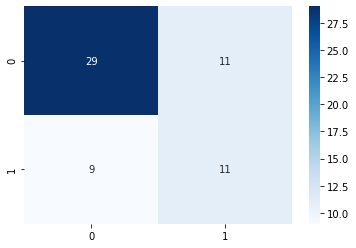

In [ ]:
#hide_input
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='Blues')

## First_N_Points Model

Next, we will build a model which takes the first n-points including baseline to use in our classification task

In [ ]:
#hide_input
df = pd.read_csv('data/train_df_5f.csv')
df, cont_names = prepare_df_firstnpt(features, df, 4)
procs = [Categorify, FillMissing, Normalize]
y_names = 'Stage_Progress'
y_block = CategoryBlock()
cat_names = ['race', 'gender']

In [ ]:
#hide_output
train_df = df[df['fold']!= 4].reset_index(drop=True)
train_df = train_df[~train_df['id'].isin([281, 134, 7])].reset_index(drop=True)
test_df = df[df['fold']== 4].reset_index(drop=True)
#cat_names.remove('creatinine_2_na')

for i in range(4):

    dls, tabdf = get_tabpandas_dls(i, train_df, procs, cat_names, cont_names, y_names, 32)
    emb_szs = get_emb_sz(tabdf)
    learn = tabular_learner(dls, [100,50], 
                            metrics=accuracy, 
                            cbs=[SaveModelCallback(monitor='accuracy', 
                                                   fname=f'tab_fnpt_{i}')])
    
    learn.fit_one_cycle(10, 0.002)

epoch,train_loss,valid_loss,accuracy,time
0,0.777829,0.680378,0.650000,00:00
1,0.735286,0.673316,0.616667,00:00
2,0.672835,0.668352,0.566667,00:00
3,0.625120,0.658156,0.616667,00:00
4,0.575427,0.650642,0.633333,00:00
5,0.529148,0.654912,0.633333,00:00
6,0.490730,0.673825,0.600000,00:00
7,0.459814,0.704808,0.600000,00:00
8,0.433798,0.732066,0.600000,00:00
9,0.409933,0.740352,0.600000,00:00


Better model found at epoch 0 with accuracy value: 0.6499999761581421.


epoch,train_loss,valid_loss,accuracy,time
0,0.824170,0.726858,0.333333,00:00
1,0.791442,0.716590,0.366667,00:00
2,0.743621,0.696471,0.483333,00:00
3,0.684927,0.686011,0.516667,00:00
4,0.637892,0.683588,0.583333,00:00
5,0.594458,0.667398,0.666667,00:00
6,0.557956,0.673925,0.683333,00:00
7,0.521680,0.676724,0.700000,00:00
8,0.493856,0.677449,0.700000,00:00
9,0.470854,0.687718,0.683333,00:00


Better model found at epoch 0 with accuracy value: 0.3333333432674408.
Better model found at epoch 1 with accuracy value: 0.36666667461395264.
Better model found at epoch 2 with accuracy value: 0.4833333194255829.
Better model found at epoch 3 with accuracy value: 0.5166666507720947.
Better model found at epoch 4 with accuracy value: 0.5833333134651184.
Better model found at epoch 5 with accuracy value: 0.6666666865348816.
Better model found at epoch 6 with accuracy value: 0.6833333373069763.
Better model found at epoch 7 with accuracy value: 0.699999988079071.


epoch,train_loss,valid_loss,accuracy,time
0,0.704449,0.681430,0.655172,00:00
1,0.667345,0.668573,0.672414,00:00
2,0.622968,0.643322,0.655172,00:00
3,0.587348,0.622517,0.706897,00:00
4,0.547483,0.604273,0.741379,00:00
5,0.514833,0.587999,0.724138,00:00
6,0.478616,0.580074,0.724138,00:00
7,0.447998,0.574314,0.724138,00:00
8,0.426066,0.574939,0.741379,00:00
9,0.406265,0.577266,0.775862,00:00


Better model found at epoch 0 with accuracy value: 0.6551724076271057.
Better model found at epoch 1 with accuracy value: 0.6724137663841248.
Better model found at epoch 3 with accuracy value: 0.7068965435028076.
Better model found at epoch 4 with accuracy value: 0.7413793206214905.
Better model found at epoch 9 with accuracy value: 0.7758620977401733.


epoch,train_loss,valid_loss,accuracy,time
0,0.774835,0.703346,0.423729,00:00
1,0.754138,0.727814,0.322034,00:00
2,0.701426,0.741559,0.355932,00:00
3,0.653895,0.739634,0.440678,00:00
4,0.600402,0.733774,0.474576,00:00
5,0.553787,0.722291,0.542373,00:00
6,0.518838,0.725931,0.542373,00:00
7,0.492905,0.732549,0.559322,00:00
8,0.463772,0.731249,0.593220,00:00
9,0.443782,0.736462,0.593220,00:00


Better model found at epoch 0 with accuracy value: 0.4237288236618042.
Better model found at epoch 3 with accuracy value: 0.4406779706478119.
Better model found at epoch 4 with accuracy value: 0.47457626461982727.
Better model found at epoch 5 with accuracy value: 0.5423728823661804.
Better model found at epoch 7 with accuracy value: 0.5593220591545105.
Better model found at epoch 8 with accuracy value: 0.5932203531265259.


In [ ]:
#hide_output
test_df = test_df[~test_df['id'].isin([299,67,255])].reset_index(drop=True)
test_dl = dls.test_dl(test_df)
preds = []
for i in range(4):
    dls, tabdf = get_tabpandas_dls(i, train_df, procs, cat_names, cont_names, y_names, 32)
    emb_szs = get_emb_sz(tabdf)
    learn = tabular_learner(dls, [100,50], 
                        metrics=accuracy, 
                        cbs=[SaveModelCallback(monitor='accuracy')])
    
    learn.load(f'tab_fnpt_{i}')
    pred, y_pred = learn.get_preds(dl=test_dl)
    preds.append(pred)
  
y_true = test_dl.y.values
y_pred = np.array(torch.argmax(torch.stack(preds).mean(0),1))

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [ ]:
#hide_input
print(f'5-fold accuracy score: {accuracy_score(y_true, y_pred):.2f}')

5-fold accuracy score: 0.70


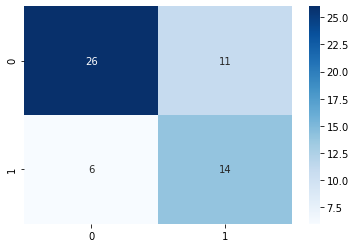

In [ ]:
#hide_input
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='Blues')

## Does including medication data help?

In [ ]:
#hide_input
meds = pd.read_csv('data/dataScienceTask/T_meds.csv')
meds = meds[meds['end_day'] < 650]
meddf = pd.DataFrame(columns=med2como.keys())
meddf['id'] = range(0,300)

In [ ]:
#hide_input
for i in range(300):
    pat = meds[meds['id']==i]
    med = pd.DataFrame(columns=list(med2como.keys()))
    medstatus = {e:0 for e in pat['drug'].unique()}

    for drug in pat['drug'].unique():
        doses = pat[pat['drug']==drug]['daily_dosage'].values
        
        inidose = doses[0]
        change = 1
        
        for dose in doses[1:]:
            if dose>inidose:
                change = 2

        meddf.loc[i,drug] = change

In [ ]:
#hide_input
meddf = meddf.fillna(0)
med_cat_cols = list(meddf.columns[:-1])
meddf.head(5)

,atorvastatin,losartan,metformin,rosuvastatin,pravastatin,carvedilol,valsartan,metoprolol,simvastatin,bisoprolol,atenolol,lovastatin,olmesartan,irbesartan,canagliflozin,dapagliflozin,telmisartan,labetalol,nebivolol,pitavastatin,propranolol,id
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
4,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4


In the above, `0` means the patient is not on the medicine, `1` means the patient is on the medicine and dosage was not increased at any point during the study and `2` means the patient is on the medicine and the dosage was increased dueing the study period. 

In [ ]:
#hide_input
df = pd.read_csv('data/train_df_5f.csv')
features = get_features("data/dataScienceTask/")
tp1 = 200
tp2 = 400
df, cont_names = prepare_df_ntimepoint(features, df, 650, [tp1, tp2])
df = df.merge(meddf, on='id')
procs = [Categorify, FillMissing, Normalize]
cat_names = ['race', 'gender']+med_cat_cols
y_names = 'Stage_Progress'

In [ ]:
#hide_output
train_df = df[df['fold']!= 4].reset_index(drop=True)
test_df = df[df['fold']== 4].reset_index(drop=True)

for i in range(4):
    dls, tabdf = get_tabpandas_dls(i, train_df, procs, cat_names, cont_names, y_names, 32)
    emb_szs = get_emb_sz(tabdf)
    learn = tabular_learner(dls, [100,50], 
                            metrics=accuracy, 
                            cbs=[SaveModelCallback(monitor='accuracy', 
                                                   fname=f'tab_3pt_meds_{i}')])
    
    learn.fit_one_cycle(10, 0.002)

epoch,train_loss,valid_loss,accuracy,time
0,0.750388,0.675111,0.700000,00:00
1,0.715781,0.662164,0.683333,00:00
2,0.665363,0.652993,0.650000,00:00
3,0.612202,0.648965,0.683333,00:00
4,0.564104,0.646938,0.666667,00:00
5,0.524437,0.645424,0.700000,00:00
6,0.491141,0.658032,0.733333,00:00
7,0.462605,0.674812,0.716667,00:00
8,0.439426,0.702039,0.650000,00:00
9,0.417578,0.717549,0.633333,00:00


Better model found at epoch 0 with accuracy value: 0.699999988079071.
Better model found at epoch 6 with accuracy value: 0.7333333492279053.


epoch,train_loss,valid_loss,accuracy,time
0,0.709985,0.659484,0.700000,00:00
1,0.683692,0.638468,0.683333,00:00
2,0.638436,0.624579,0.666667,00:00
3,0.597847,0.622997,0.700000,00:00
4,0.547733,0.634225,0.700000,00:00
5,0.515652,0.630646,0.683333,00:00
6,0.485755,0.636387,0.716667,00:00
7,0.457840,0.649950,0.666667,00:00
8,0.434562,0.662683,0.650000,00:00
9,0.419850,0.676213,0.633333,00:00


Better model found at epoch 0 with accuracy value: 0.699999988079071.
Better model found at epoch 6 with accuracy value: 0.7166666388511658.


epoch,train_loss,valid_loss,accuracy,time
0,0.726752,0.697180,0.483333,00:00
1,0.705733,0.689755,0.500000,00:00
2,0.662952,0.671705,0.616667,00:00
3,0.613778,0.652993,0.633333,00:00
4,0.573236,0.622532,0.666667,00:00
5,0.532279,0.599803,0.650000,00:00
6,0.501913,0.594146,0.683333,00:00
7,0.475226,0.593825,0.700000,00:00
8,0.453405,0.597053,0.683333,00:00
9,0.433427,0.598414,0.683333,00:00


Better model found at epoch 0 with accuracy value: 0.4833333194255829.
Better model found at epoch 1 with accuracy value: 0.5.
Better model found at epoch 2 with accuracy value: 0.6166666746139526.
Better model found at epoch 3 with accuracy value: 0.6333333253860474.
Better model found at epoch 4 with accuracy value: 0.6666666865348816.
Better model found at epoch 6 with accuracy value: 0.6833333373069763.
Better model found at epoch 7 with accuracy value: 0.699999988079071.


epoch,train_loss,valid_loss,accuracy,time
0,0.758792,0.717645,0.333333,00:00
1,0.728776,0.690556,0.500000,00:00
2,0.683583,0.652527,0.683333,00:00
3,0.649115,0.605243,0.716667,00:00
4,0.605362,0.566075,0.750000,00:00
5,0.569001,0.540783,0.783333,00:00
6,0.535546,0.526307,0.800000,00:00
7,0.510804,0.518003,0.766667,00:00
8,0.482868,0.517259,0.750000,00:00
9,0.459480,0.521494,0.716667,00:00


Better model found at epoch 0 with accuracy value: 0.3333333432674408.
Better model found at epoch 1 with accuracy value: 0.5.
Better model found at epoch 2 with accuracy value: 0.6833333373069763.
Better model found at epoch 3 with accuracy value: 0.7166666388511658.
Better model found at epoch 4 with accuracy value: 0.75.
Better model found at epoch 5 with accuracy value: 0.7833333611488342.
Better model found at epoch 6 with accuracy value: 0.800000011920929.


In [ ]:
#hide
categorical_dims = {o:len(i) for o,i in dls.train.categorify.classes.items()}
test_cats = dict(test_df[list(categorical_dims.keys())].nunique())
test_cats = {k:v+1 for k, v in test_cats.items()}

In [ ]:
#hide
for k, v in categorical_dims.items():
    if test_cats[k] > v:
        print(f'{k}')

carvedilol
valsartan
metoprolol
propranolol


In [ ]:
#hide
test_df = test_df[test_df['metoprolol'] != 2]
test_df = test_df[test_df['simvastatin'] != 2].reset_index(drop=True)

In [ ]:
#hide_output
test_dl = dls.test_dl(test_df)

preds = []
for i in range(4):
    dls, tabdf = get_tabpandas_dls(i, train_df, procs, cat_names, cont_names, y_names, 32)
    emb_szs = get_emb_sz(tabdf)
    learn = tabular_learner(dls, [100,50], 
                        metrics=accuracy, 
                        cbs=[SaveModelCallback(monitor='accuracy')])
    
    learn.load(f'tab_3pt_meds_{i}')
    pred, y_true = learn.get_preds(dl=test_dl)
    preds.append(pred)

y_true = test_dl.y.values
y_pred = np.array(torch.argmax(torch.stack(preds).mean(0),1))

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [ ]:
#hide_input
print(f'5-fold accuracy score: {accuracy_score(y_true, y_pred):.2f}')

5-fold accuracy score: 0.69


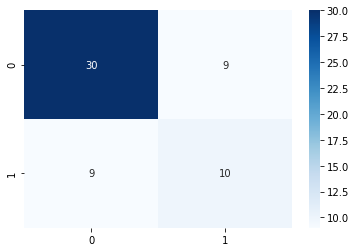

In [ ]:
#hide_input
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='Blues')